In [1]:
import torch
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing
from src.regressors.gru_regression import ConsumptionGRURegressor
from src.models.gru import GRUModel
from src.dataset import PecanDataset, PecanDataModule
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd
import numpy as np

In [2]:
pecan_dataset = PecanParticipantPreProcessing('661_test_13', 'data/participants_data/1min/',
                                                   60)
train_sequences, test_sequences, val_sequences = pecan_dataset.get_sequences()
n_features = pecan_dataset.get_n_features()[1]

scaler = pecan_dataset.get_scaler()
ckpt = 'checkpoints/participants/661_test_13/sigmoid/GRU/best/best-GRU-chpkt-pecanstreet-participant-id-661_test_13_epoch=197-val_loss=0.00000.ckpt'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[!] - Trainable dataframe shape - (129086, 13)
[*] Train dataframe shape: (90360, 13)
[*] Validation dataframe shape: (25817, 13)
[*] Test dataframe shape: (12909, 13)


100%|█████████████████████████████████████████████████████████████████████████| 25757/25757 [00:02<00:00, 10661.40it/s]

[!] Train sequence shape: (60, 13)
[!] Test sequence shape: (60, 13)
[!] Val sequence shape: (60, 13)
[!] Len of train, val and test sequence: 90300 25757 12849


In [47]:
device

device(type='cuda', index=0)

In [48]:
data_module = PecanDataModule(
    device,
    train_sequences,
    test_sequences,
    val_sequences,
    32,
    6
)
data_module.setup()


In [49]:
std_df = pecan_dataset.get_standart_df_features()

In [50]:
features = pecan_dataset.get_features_df()

In [51]:
data = [x for x in features.columns if x != "consumption"]
X = features[data].values
y = features['consumption']

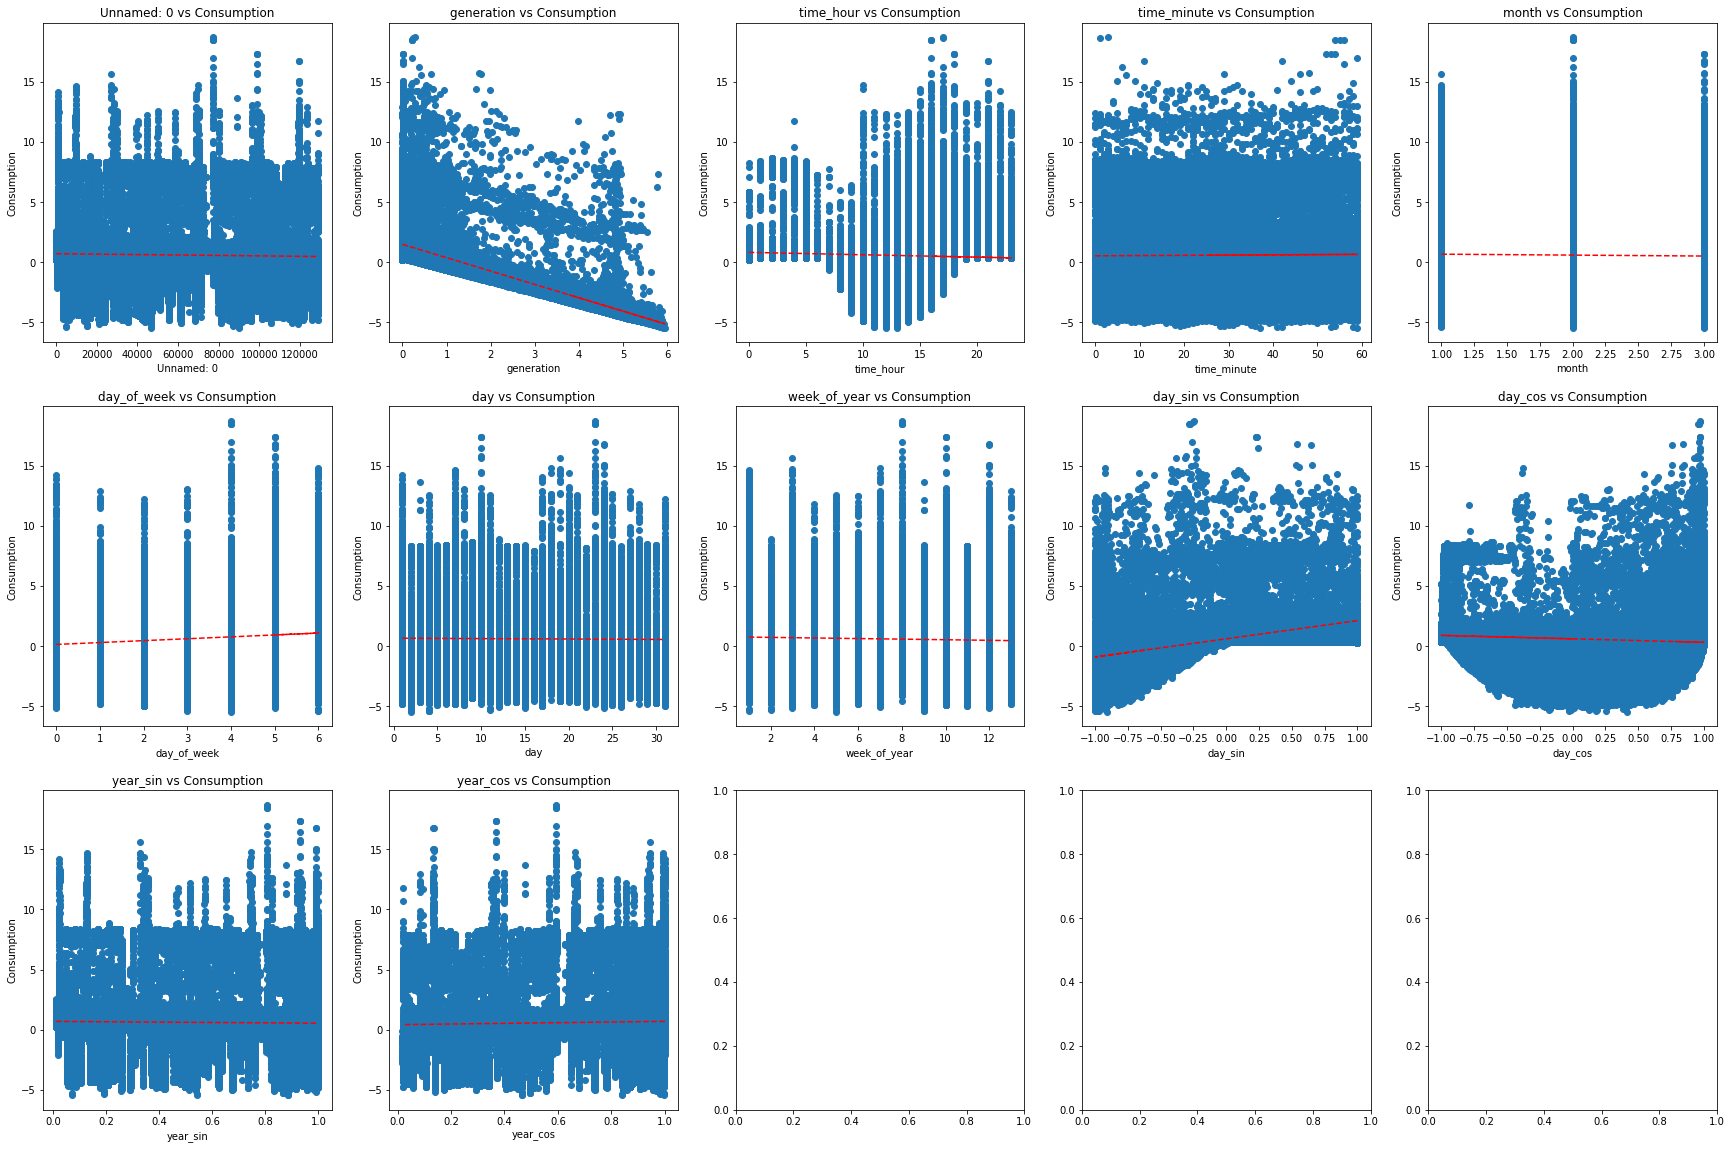

In [52]:
fig, axs = plt.subplots(nrows = 3, ncols=5, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, data)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Consumption')
    ax.set_xlabel(col)
    ax.set_ylabel('Consumption')
plt.savefig(f'etc/imgs/features/correlation_variables_661_test_13.png', dpi=300, bbox_inches='tight', transparent=False)        

In [53]:
pca = PCA(n_components = 0.99)
features_pca = pca.fit(std_df)
loadings = features_pca.components_

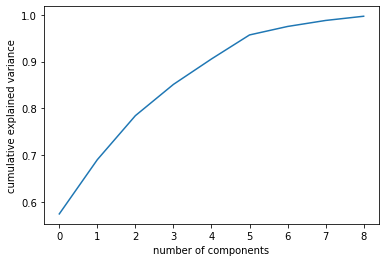

In [54]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [55]:
print(pca.n_components_)

9


In [56]:
pca_result_df = pd.DataFrame(pca.components_, columns = pecan_dataset.get_test_data().columns)

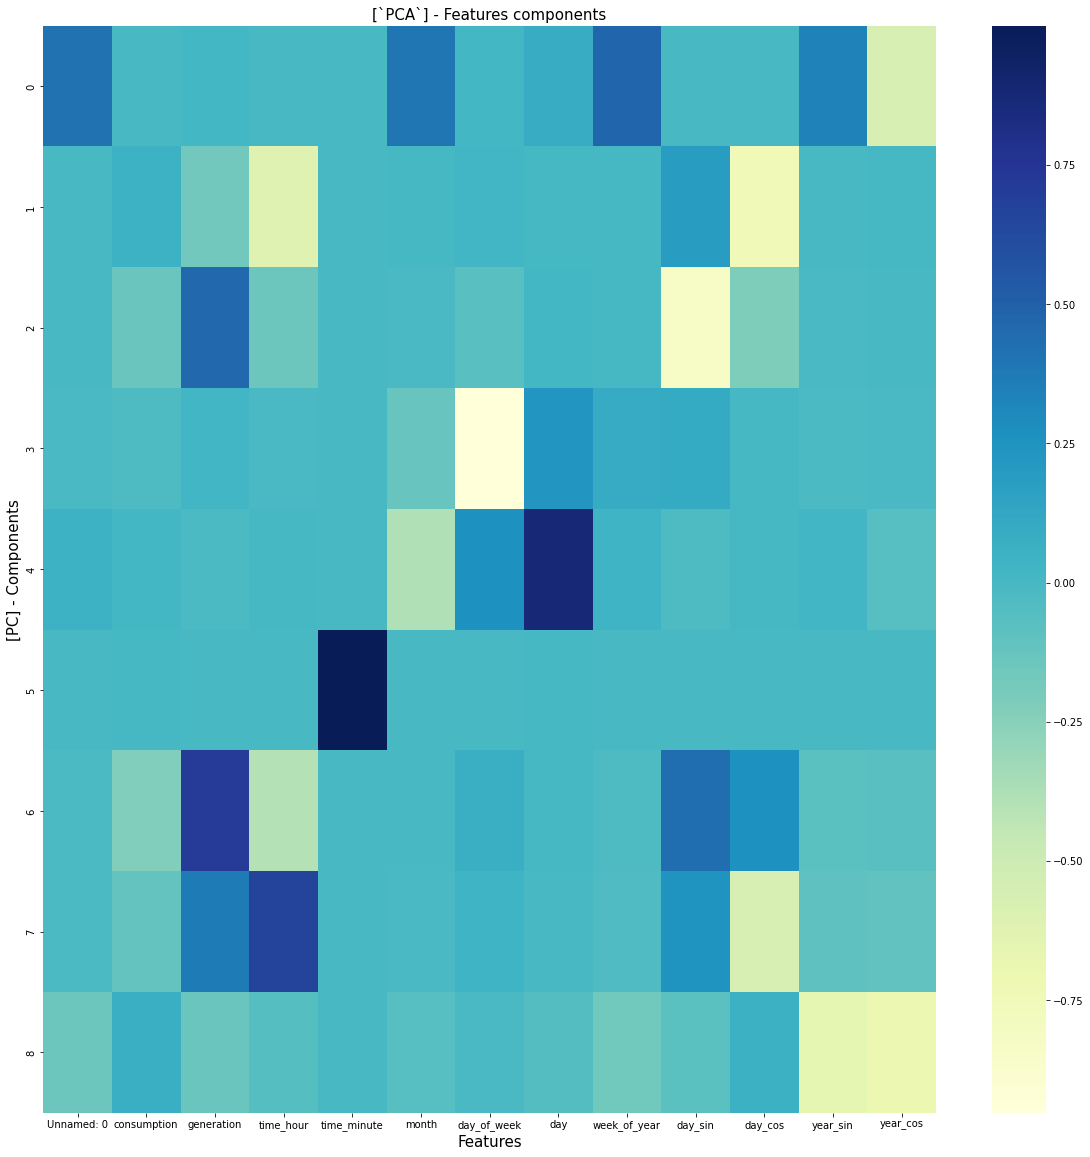

In [57]:
import seaborn as sns
plt.figure(figsize=(20, 20))
plt.title(f'[`PCA`] - Features components', fontsize=15)

ax = sns.heatmap(pca_result_df,  cmap="YlGnBu")
plt.xlabel('Features', fontsize=15)
plt.ylabel('[PC] - Components', fontsize=15)
plt.savefig(f'etc/imgs/features/feature_importance_PCA_661_test_13.svg', dpi=600, bbox_inches='tight')
plt.show()

In [58]:
n_pcs= pca.n_components_ 
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = pecan_dataset.get_test_data().columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

np.abs(pca.components_[1])
most_important_names

['year_cos',
 'day_cos',
 'day_sin',
 'day_of_week',
 'day',
 'time_minute',
 'generation',
 'time_hour',
 'year_cos']